In [17]:
from torchvision import datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader
import torch.optim as optim
from cleverhans.torch.attacks.projected_gradient_descent import (projected_gradient_descent)

import matplotlib.pyplot as plt
import numpy as np

In [27]:
train_dataset = datasets.MNIST(root="./datasets/", train=True, download=True)
test_dataset = datasets.MNIST(root="./datasets/", train=False, download = False)

In [29]:
class_names = train_dataset.classes

In [31]:
img, label = train_dataset[0]
img, label

(<PIL.Image.Image image mode=L size=28x28>, 5)

Text(0.5, 1.0, '5 - five')

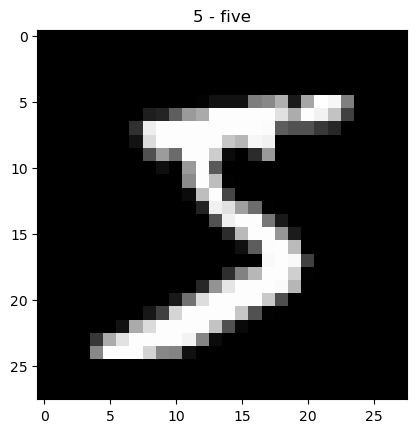

In [33]:
import matplotlib.pyplot as plt
plt.imshow(img, cmap='gray')
plt.title(f"{class_names[label]}")

In [35]:
import numpy as np

def img_superimpose(img, ax):
    w, h = img.shape
    color_map = plt.cm.get_cmap('gray_r')
    ax.imshow(img, cmap='gray')
    for x in range(w):
        for y in range(h):
            color = color_map(img[x][y])
            ax.annotate(str(img[x][y]), xy=(y,x), horizontalalignment='center', verticalalignment='center',color=color)
            plt.axis(False)

C:\Users\User\AppData\Local\Temp\ipykernel_6964\1820127681.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('gray_r')


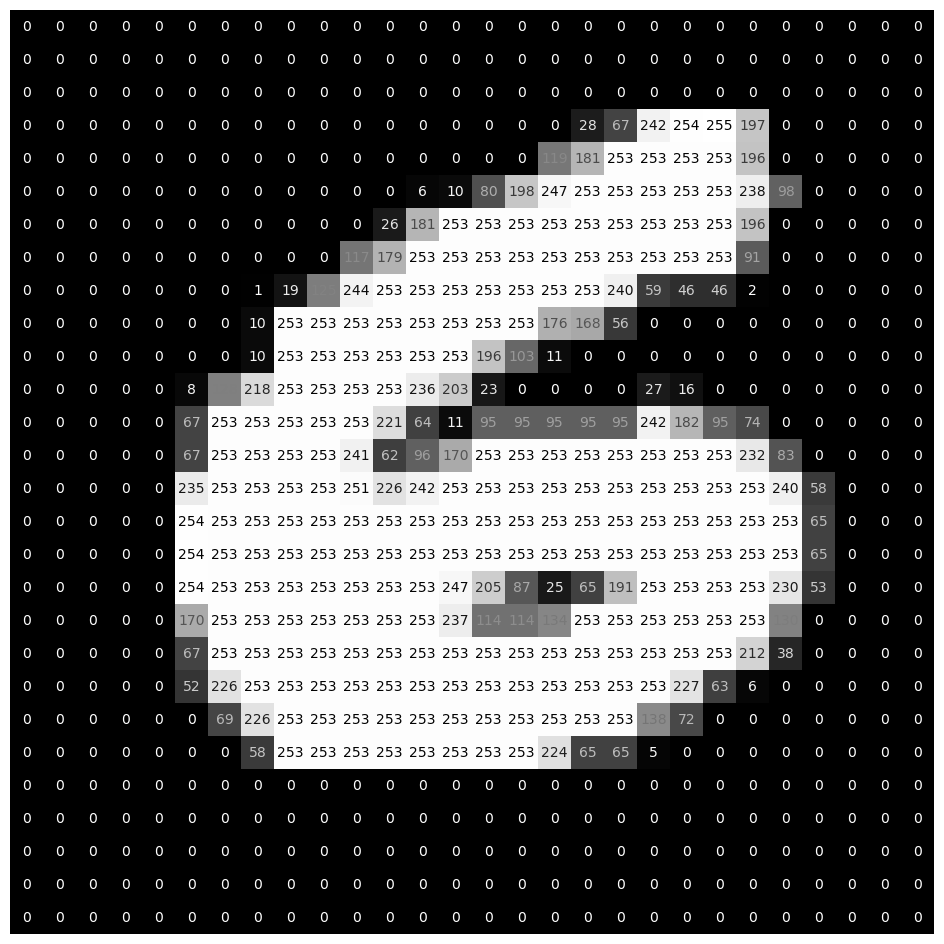

In [37]:
import torch
torch.manual_seed(42)
fig = plt.figure(figsize = (12,12))
ax0 = fig.add_subplot(1,1,1)
rand_ind = torch.randint(0, len(train_dataset), size=[1]).item()

img0 = train_dataset.data[rand_ind]
img0 = img0.numpy()
img_superimpose(img0, ax0)

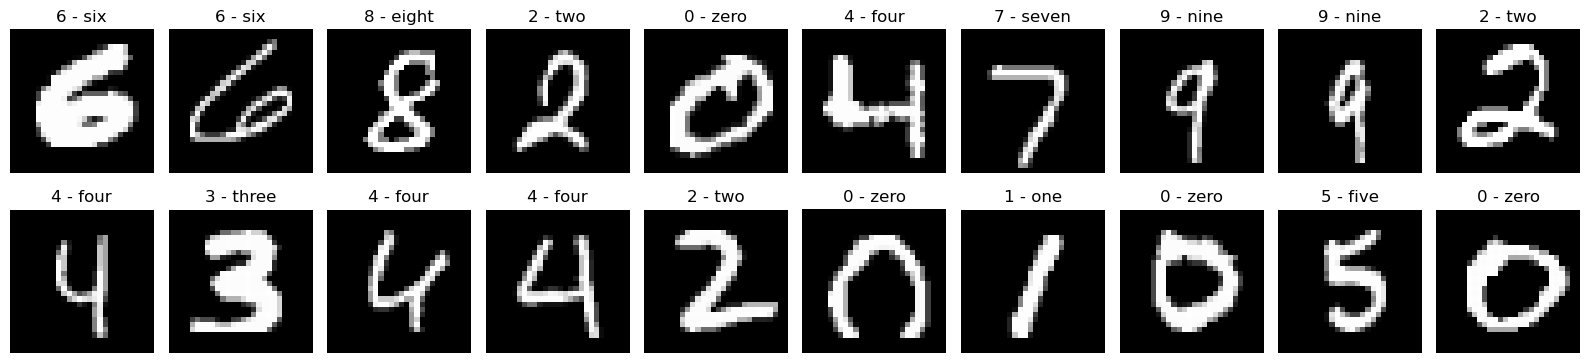

In [39]:
import torch
torch.manual_seed(42)     # Search on the internet why '42' is special or
                          # even '42 * 2' = 84

fig = plt.figure(figsize=(16, 4))
rows, cols = 2, 10

for i in range(1, (rows*cols) + 1):
    rand_ind = torch.randint(0, len(train_dataset), size=[1]).item()
    img, label = train_dataset[rand_ind]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img, cmap='gray')
    plt.title(f"{class_names[label]}")
    plt.axis(False)
    plt.tight_layout()

In [43]:
mnist_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

In [45]:
train_dataset = datasets.MNIST(root="./datasets", train=True, download = False, transform = mnist_transforms)
test_dataset = datasets.MNIST(root="./datasets", train=False, download = False, transform = mnist_transforms)

In [47]:
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset = train_dataset, lengths=[train_size, val_size])

In [49]:
train_loader = DataLoader(dataset = train_dataset, batch_size = 32, shuffle=True)
test_loader = DataLoader(dataset = test_dataset, batch_size = 32, shuffle=True)
val_loader = DataLoader(dataset = val_dataset, batch_size = 32, shuffle=True)

In [51]:
from torch import nn
class LeNet5V1(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature = nn.Sequential(
            #1
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2),   # 28*28->32*32-->28*28
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 14*14
            
            #2
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),  # 10*10
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 5*5
            
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16*5*5, out_features=120),
            nn.Tanh(),
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=10),
        )
        
    def forward(self, x):
        return self.classifier(self.feature(x))
# class LeNet5V1(nn.Module):
#     def __init__(self):
#         super(LeNet5V1, self).__init__()
#         self.conv1 = nn.Conv2d(1, 32, 3, 1)
#         self.conv2 = nn.Conv2d(32, 64, 3, 1)
#         self.dropout1 = nn.Dropout(0.25)
#         self.dropout2 = nn.Dropout(0.5)
#         self.fc1 = nn.Linear(9216, 128)
#         self.fc2 = nn.Linear(128, 10)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = F.relu(x)
#         x = self.conv2(x)
#         x = F.relu(x)
#         x = F.max_pool2d(x, 2)
#         x = self.dropout1(x)
#         x = torch.flatten(x, 1)
#         x = self.fc1(x)
#         x = F.relu(x)
#         x = self.dropout2(x)
#         x = self.fc2(x)
#         output = F.log_softmax(x, dim=1)
#         return output


In [53]:
from torchmetrics import Accuracy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet5V1().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 1e-4)
EPOCHS = 10
accuracy = Accuracy(task='multiclass', num_classes=10)
eps= [0.01, 0.03, 0.06, 0.1, 0.3, 0.5]

In [55]:
from tqdm.notebook import tqdm

accuracy = accuracy.to(device)

for epoch in tqdm(range(EPOCHS)):
    # Training loop
    train_acc = 0.0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        X = projected_gradient_descent(model, X, eps[0], eps[0]/10, 40, np.inf )
        model.train()
        
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        
        acc = accuracy(y_pred, y)
        train_acc += acc
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_acc /= len(train_loader)
        
    # Validation loop
    val_loss, val_acc = 0.0, 0.0
    model.eval()
    with torch.inference_mode():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            
            y_pred = model(X)
            
            loss = loss_fn(y_pred, y)
            val_loss += loss.item()
            
            acc = accuracy(y_pred, y)
            val_acc += acc
            
        val_loss /= len(val_loader)
        val_acc /= len(val_loader)
    
    print(f"Epoch: {epoch}| Train acc: {(100* train_acc):.5f}| Val loss: {val_loss: .5f}| Val acc: {(100*val_acc): .5f}")
                
        
        
    

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 0| Train acc: 83.62893| Val loss:  0.28330| Val acc:  91.97141
Epoch: 1| Train acc: 93.09280| Val loss:  0.16995| Val acc:  94.96342


In [57]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "lenet5_v1_mnist_adv.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Saving the model
print(f"Saving the model: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

# Loading the saved model
model_lenet5_v1_mnist_adv_loaded = LeNet5V1()
model_lenet5_v1_mnist_adv_loaded.load_state_dict(torch.load(MODEL_SAVE_PATH))

Saving the model: models\lenet5_v1_mnist_adv.pth


C:\Users\User\AppData\Local\Temp\ipykernel_6964\2667992705.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_lenet5_v1_mnist_adv_loaded.load_state_dict(torch.load(M

<All keys matched successfully>

In [59]:
test_loss, test_acc = 0, 0

model = model_lenet5_v1_mnist_adv_loaded.to(device)

model.eval()
with torch.inference_mode():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        
        test_loss += loss_fn(y_pred, y)
        test_acc += accuracy(y_pred, y)
        
    test_loss /= len(test_loader)
    test_acc /= len(test_loader)

print(f"Test loss: {test_loss: .5f}| Test acc: {(100* test_acc): .5f}")

Test loss:  0.17540| Test acc:  94.95807


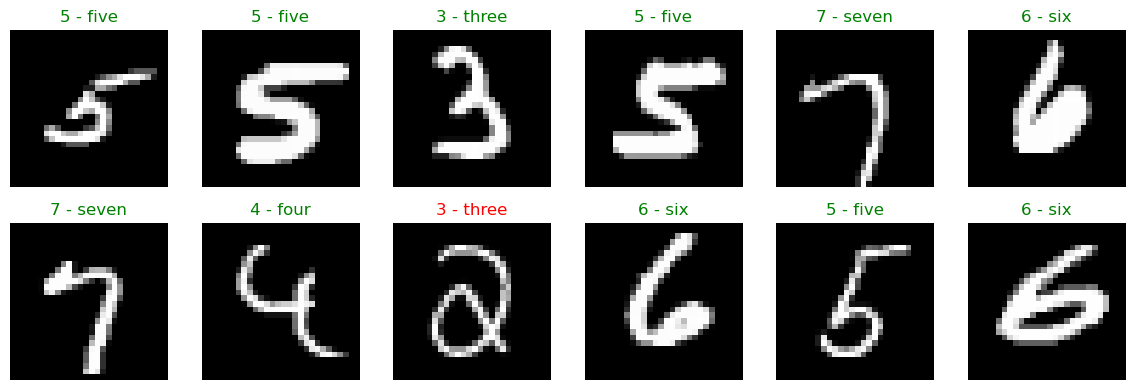

In [60]:
# See random images with their labels
torch.manual_seed(42)  # setting random seed
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(12, 4))

rows, cols = 2, 6
for i in range(1, (rows * cols) + 1):
    random_idx = torch.randint(0, len(test_dataset), size=[1]).item()
    img, label_gt = test_dataset[random_idx]
    img_temp = img.unsqueeze(dim=0).to(device)
    # print(img.shape)
    label_pred = torch.argmax(model_lenet5_v1_mnist_adv_loaded(img_temp))
    fig.add_subplot(rows, cols, i)
    img = img.permute(1, 2, 0)    # CWH --> WHC
    plt.imshow(img, cmap='gray')
    if label_pred == label_gt:
        plt.title(class_names[label_pred], color='g') # for correct prediction
    else:
        plt.title(class_names[label_pred], color='r') # for incorrect prediction
    plt.axis(False)
    plt.tight_layout();